<a href="https://colab.research.google.com/github/HazelvdW/context-framed-listening/blob/main/framed_listening_TFIDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Framed Listening: **TF-IDF analyses**
> By **Hazel A. van der Walle** (PhD student, Music, Durham University), September 2025.

This notebook mirrors the [Word2Vec analysis](https://github.com/HazelvdW/context-framed-listening/blob/main/framed_listening_Word2Vec.ipynb) structure for this study.

Here, we run the cosine similarity analyses and semantic similarity analyses using Term Frequency (TF) and Inverse Document Frequency (IDF) measures.

For both of these analyses, two levels of investigation are conducted:
1. a broad cateorisation, grouping METs by the genre of the clip (N=4) and context (N=4) pairing (*= 16 documents*)
2. grouping METs by specific clip (N=16) and context (N=4) pairing (*= 64 documents*)


Overviews are described at the start of each analysis section, and Summaries at the end listing the file outputs.



---

All datasets generated and used for this study are openly available on GitHub https://github.com/HazelvdW/context-framed-listening.

In [1]:
!rm -r context-framed-listening
# Clone the GitHub repository
!git clone https://github.com/HazelvdW/context-framed-listening.git

Cloning into 'context-framed-listening'...
remote: Enumerating objects: 180, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 180 (delta 11), reused 8 (delta 2), pack-reused 153 (from 1)
Receiving objects: 100% (180/180), 6.84 MiB | 14.56 MiB/s, done.
Resolving deltas: 100% (104/104), done.


Refresh files to see **"context-framed-listening"**.


---

## Setup

In [2]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns

Load in the data file "**dataMET_preprocessed.csv**" that contains the preprocessed text data of participants' thought desciptions, generated using the code notebook titled [framed_listening_text_prep](https://github.com/HazelvdW/context-framed-listening/blob/main/framed_listening_text_prep.ipynb)

In [3]:
dataMETpre = pd.read_csv("/content/context-framed-listening/NLP_outputs/dataMET_preprocessed.csv")

---
## Cosine Similarity Analyses


**OUTPUTS:**

**Version 1 (Genre-Context):**

* Groups by genre and context (broader categorisation)
* Produces 16 document combinations (4 genres × 4 contexts)


**Version 2 (Clip-Context):**

* Groups by specific clip and context pairing
* Produces 64 document combinations (16 clips × 4 contexts)

====================================
### Version 1: Genre-Context Cosine Matrix
====================================

Combine the preprocessed MET descriptions from `dataMETpre` into "METdocs".

In [4]:
# Initialise DataFrame for Version 1
METdocs_v1 = pd.DataFrame(index=range(0,1), columns=dataMETpre.columns)
rowIndex = 0

# Iterate through each unique context word and genre
for idContext in np.unique(dataMETpre['context_word']):
    for idGenre in np.unique(dataMETpre['clip_genre']):
        # Create masks to filter data
        contextMask = dataMETpre['context_word'] == idContext
        genreMask = dataMETpre['clip_genre'] == idGenre

        # Combined mask
        mask = [all(tup) for tup in zip(contextMask, genreMask)]
        filt_ContextGenreData = dataMETpre[mask]

        # Concatenate all text descriptions
        descrSeries = filt_ContextGenreData['preprocessed_METdescr']

        # Join descriptions with marker
        joinedstring = ""
        for ival in range(0, len(descrSeries.values)):
            joinedstring = joinedstring + str(descrSeries.values[ival]) + " endofasubhere "

        # Assign values to dataframe
        METdocs_v1.loc[rowIndex, 'preprocessed_METdescr'] = joinedstring
        METdocs_v1.loc[rowIndex, 'idGenreContext'] = idContext[0:3] + "_" + idGenre[0:3]

        # Assign context code
        if idContext[0:3] == 'bar':
            METdocs_v1.loc[rowIndex, 'context_code'] = 'BAR'
        elif idContext[0:3] == 'con':
            METdocs_v1.loc[rowIndex, 'context_code'] = 'CON'
        elif idContext[0:3] == 'mov':
            METdocs_v1.loc[rowIndex, 'context_code'] = 'MOV'
        elif idContext[0:3] == 'vid':
            METdocs_v1.loc[rowIndex, 'context_code'] = 'VID'

        # Assign genre code
        if idGenre[0:3] == '80s':
            METdocs_v1.loc[rowIndex, 'genre_code'] = '80s'
        elif idGenre[0:3] == 'Jaz':
            METdocs_v1.loc[rowIndex, 'genre_code'] = 'Jaz'
        elif idGenre[0:3] == 'Met':
            METdocs_v1.loc[rowIndex, 'genre_code'] = 'Met'
        elif idGenre[0:3] == 'Ele':
            METdocs_v1.loc[rowIndex, 'genre_code'] = 'Ele'

        rowIndex = rowIndex + 1

# Filter and save Version 1
METdocs_v1 = METdocs_v1.filter(['context_code', 'genre_code', 'preprocessed_METdescr', 'idGenreContext'], axis=1)
METdocs_v1.to_csv('/content/context-framed-listening/NLP_outputs/TFIDF/METdocs_v1_GenreContext.csv', encoding='utf-8')

print(f"Version 1: Created {len(METdocs_v1)} documents (Genre-Context combinations)")
display(METdocs_v1.head(5))


Version 1: Created 16 documents (Genre-Context combinations)


,context_code,genre_code,preprocessed_METdescr,idGenreContext
0,BAR,80s,kind sad melancholy happy upbeat emotionally c...,bar_80s
1,BAR,Ele,feel busy drive something important something ...,bar_Ele
2,BAR,Jaz,dynamic could sway someone care could sit drin...,bar_Jaz
3,BAR,Met,upbeat would never hear maybe end credit somet...,bar_Met
4,CON,80s,bland lift something something would specifica...,con_80s


Compute cosine similarity for version 1:

In [5]:
# Initialise TF-IDF vectoriser
TFIDF_vectoriser_v1 = TfidfVectorizer(sublinear_tf=False)

# Load the METdocs data for Version 1
wordsin_v1 = METdocs_v1

# Calculate the TF-IDF matrix
print("Computing TF-IDF matrix for Version 1...")
TFIDF_matrix_v1 = TFIDF_vectoriser_v1.fit_transform(wordsin_v1['preprocessed_METdescr'])

# Create DataFrame with TF-IDF scores
df_TFIDF_v1 = pd.DataFrame()
doc_index = 0

for ival in range(0, TFIDF_matrix_v1.shape[0]):
    df_temp = pd.DataFrame(
        TFIDF_matrix_v1[ival].T.todense(),
        index=TFIDF_vectoriser_v1.get_feature_names_out(),
        columns=[wordsin_v1['idGenreContext'].iloc[doc_index]]
    )
    df_TFIDF_v1 = pd.concat([df_TFIDF_v1, df_temp], axis=1)
    doc_index += 1

# Save TF-IDF weights dictionary
TFIDF_dic_v1 = dict(zip(
    TFIDF_vectoriser_v1.get_feature_names_out(),
    TFIDF_vectoriser_v1.idf_
))

# Save TF-IDF scores to CSV
df_TFIDF_v1.to_csv('/content/context-framed-listening/NLP_outputs/TFIDF/TFIDF_scores_v1_GenreContext.csv', encoding='utf-8')

print(f"Version 1: TF-IDF matrix shape: {TFIDF_matrix_v1.shape}")
print(f"Number of unique terms: {len(TFIDF_vectoriser_v1.get_feature_names_out())}")

# Calculate cosine similarity matrix
print("Computing cosine similarity matrix for Version 1...")
cosineMatrix_TFIDF_v1 = cosine_similarity(TFIDF_matrix_v1, TFIDF_matrix_v1)

# Create labeled DataFrame
cosineMatrix_TFIDF_v1_df = pd.DataFrame(
    cosineMatrix_TFIDF_v1,
    index=wordsin_v1['idGenreContext'],
    columns=wordsin_v1['idGenreContext']
)

# Save cosine similarity matrix
cosineMatrix_TFIDF_v1_df.to_csv('/content/context-framed-listening/NLP_outputs/TFIDF/cosineMatrix_TFIDF_v1_GenreContext.csv', encoding='utf-8')

print("\nVersion 1 TF-IDF Cosine Similarity Matrix:")
display(cosineMatrix_TFIDF_v1_df)

Computing TF-IDF matrix for Version 1...
Version 1: TF-IDF matrix shape: (16, 3328)
Number of unique terms: 3328
Computing cosine similarity matrix for Version 1...

Version 1 TF-IDF Cosine Similarity Matrix:


idGenreContext,bar_80s,bar_Ele,bar_Jaz,bar_Met,con_80s,con_Ele,con_Jaz,con_Met,mov_80s,mov_Ele,mov_Jaz,mov_Met,vid_80s,vid_Ele,vid_Jaz,vid_Met
idGenreContext,,,,,,,,,,,,,,,,
bar_80s,1.000000,0.801685,0.822065,0.773303,0.818431,0.784221,0.796991,0.716298,0.782856,0.772890,0.813560,0.761737,0.801317,0.761466,0.803460,0.707039
bar_Ele,0.801685,1.000000,0.776492,0.758791,0.782290,0.812753,0.756659,0.702476,0.744499,0.799601,0.768649,0.763934,0.781420,0.805835,0.767625,0.711710
bar_Jaz,0.822065,0.776492,1.000000,0.753895,0.790823,0.758832,0.821618,0.704323,0.738652,0.750069,0.834676,0.743106,0.786235,0.743610,0.829013,0.695621
bar_Met,0.773303,0.758791,0.753895,1.000000,0.771109,0.753869,0.766607,0.814814,0.717556,0.758166,0.745955,0.818138,0.761373,0.756510,0.760093,0.813082
con_80s,0.818431,0.782290,0.790823,0.771109,1.000000,0.784301,0.801811,0.736047,0.784640,0.762335,0.795134,0.756604,0.798903,0.759134,0.792787,0.714878
con_Ele,0.784221,0.812753,0.758832,0.753869,0.784301,1.000000,0.756117,0.727357,0.724855,0.779860,0.752234,0.756728,0.775134,0.796090,0.762563,0.724026
con_Jaz,0.796991,0.756659,0.821618,0.766607,0.801811,0.756117,1.000000,0.743677,0.733907,0.733756,0.818399,0.746637,0.769099,0.730943,0.812879,0.698848
con_Met,0.716298,0.702476,0.704323,0.814814,0.736047,0.727357,0.743677,1.000000,0.667246,0.694635,0.697133,0.792774,0.712999,0.697433,0.707957,0.773019
mov_80s,0.782856,0.744499,0.738652,0.717556,0.784640,0.724855,0.733907,0.667246,1.000000,0.751434,0.774378,0.735377,0.790090,0.738012,0.747866,0.672158


====================================
### Version 2: Clip-Context Cosine Matrix
====================================

Combine the preprocessed MET descriptions from `dataMETpre` into "METdocs".

In [6]:
# Initialise DataFrame for Version 2
METdocs_v2 = pd.DataFrame(index=range(0,1), columns=dataMETpre.columns)
rowIndex = 0

# Iterate through each unique clip_context_PAIR
for idStimPair in np.unique(dataMETpre['clip_context_PAIR']):
    # Create mask for current stimulus pair
    stimPairMask = dataMETpre['clip_context_PAIR'] == idStimPair
    filt_ClipContextData = dataMETpre[stimPairMask]

    # Get the first row to extract clip and context info
    if len(filt_ClipContextData) > 0:
        first_row = filt_ClipContextData.iloc[0]
        idClip = first_row['clip_name']
        idContext = first_row['context_word']

        # Concatenate all text descriptions
        descrSeries = filt_ClipContextData['preprocessed_METdescr']

        joinedstring = ""
        for ival in range(0, len(descrSeries.values)):
            joinedstring = joinedstring + str(descrSeries.values[ival]) + " endofasubhere "

        # Assign values to dataframe
        METdocs_v2.loc[rowIndex, 'preprocessed_METdescr'] = joinedstring
        METdocs_v2.loc[rowIndex, 'clip_name'] = idClip
        METdocs_v2.loc[rowIndex, 'context_word'] = idContext
        METdocs_v2.loc[rowIndex, 'idClipContext'] = idStimPair
        METdocs_v2.loc[rowIndex, 'idGenreContext'] = idStimPair[0:3] + "_" + idClip[0:3]

        # Assign genre code
        if idClip[0:3] == '80s':
            METdocs_v2.loc[rowIndex, 'genre_code'] = '80s'
        elif idClip[0:3] == 'Jaz':
            METdocs_v2.loc[rowIndex, 'genre_code'] = 'Jaz'
        elif idClip[0:3] == 'Met':
            METdocs_v2.loc[rowIndex, 'genre_code'] = 'Met'
        elif idClip[0:3] == 'Ele':
            METdocs_v2.loc[rowIndex, 'genre_code'] = 'Ele'

        rowIndex = rowIndex + 1

# Filter and save Version 2
METdocs_v2 = METdocs_v2.filter(['context_word', 'genre_code', 'clip_name', 'preprocessed_METdescr', 'idClipContext', 'idGenreContext'], axis=1)
METdocs_v2.to_csv('/content/context-framed-listening/NLP_outputs/TFIDF/METdocs_v2_ClipContext.csv', encoding='utf-8')

print(f"Version 2: Created {len(METdocs_v2)} documents (Clip-Context combinations)")
display(METdocs_v2.head(5))

Version 2: Created 64 documents (Clip-Context combinations)


,context_word,genre_code,clip_name,preprocessed_METdescr,idClipContext,idGenreContext
0,bar,80s,80s_LOW_02,kind sad melancholy happy upbeat emotionally c...,BAR-80s_LOW_02,BAR_80s
1,bar,80s,80s_LOW_06,felt really style hawaiian hula style decor en...,BAR-80s_LOW_06,BAR_80s
2,bar,80s,80s_MED_08,old take place couple dancing good time bring ...,BAR-80s_MED_08,BAR_80s
3,bar,80s,80s_MED_13,could sit couch kid would type would play cred...,BAR-80s_MED_13,BAR_80s
4,bar,Ele,Ele_LOW_09,europe specific country electric popular outsi...,BAR-Ele_LOW_09,BAR_Ele


Compute cosine similarity for Version 2:

In [7]:
# Initialise TF-IDF vectoriser
TFIDF_vectoriser_v2 = TfidfVectorizer(sublinear_tf=False)

# Load the METdocs data for Version 2
wordsin_v2 = METdocs_v2

# Calculate the TF-IDF matrix
print("Computing TF-IDF matrix for Version 2...")
TFIDF_matrix_v2 = TFIDF_vectoriser_v2.fit_transform(wordsin_v2['preprocessed_METdescr'])

# Create DataFrame with TF-IDF scores
df_TFIDF_v2 = pd.DataFrame()
doc_index = 0

for ival in range(0, TFIDF_matrix_v2.shape[0]):
    df_temp = pd.DataFrame(
        TFIDF_matrix_v2[ival].T.todense(),
        index=TFIDF_vectoriser_v2.get_feature_names_out(),
        columns=[wordsin_v2['idClipContext'].iloc[doc_index]]
    )
    df_TFIDF_v2 = pd.concat([df_TFIDF_v2, df_temp], axis=1)
    doc_index += 1

# Save TF-IDF weights dictionary
TFIDF_dic_v2 = dict(zip(
    TFIDF_vectoriser_v2.get_feature_names_out(),
    TFIDF_vectoriser_v2.idf_
))

# Save TF-IDF scores to CSV
df_TFIDF_v2.to_csv('/content/context-framed-listening/NLP_outputs/TFIDF/TFIDF_scores_v2_ClipContext.csv', encoding='utf-8')

print(f"Version 2: TF-IDF matrix shape: {TFIDF_matrix_v2.shape}")
print(f"Number of unique terms: {len(TFIDF_vectoriser_v2.get_feature_names_out())}")

# Calculate cosine similarity matrix
print("Computing cosine similarity matrix for Version 2...")
cosineMatrix_TFIDF_v2 = cosine_similarity(TFIDF_matrix_v2, TFIDF_matrix_v2)

# Create labeled DataFrame
cosineMatrix_TFIDF_v2_df = pd.DataFrame(
    cosineMatrix_TFIDF_v2,
    index=wordsin_v2['idClipContext'],
    columns=wordsin_v2['idClipContext']
)

# Save cosine similarity matrix
cosineMatrix_TFIDF_v2_df.to_csv('/content/context-framed-listening/NLP_outputs/TFIDF/cosineMatrix_TFIDF_v2_ClipContext.csv', encoding='utf-8')

print("\nVersion 2 TF-IDF Cosine Similarity Matrix:")
display(cosineMatrix_TFIDF_v2_df)

Computing TF-IDF matrix for Version 2...
Version 2: TF-IDF matrix shape: (64, 3328)
Number of unique terms: 3328
Computing cosine similarity matrix for Version 2...

Version 2 TF-IDF Cosine Similarity Matrix:


idClipContext,BAR-80s_LOW_02,BAR-80s_LOW_06,BAR-80s_MED_08,BAR-80s_MED_13,BAR-Ele_LOW_09,BAR-Ele_LOW_14,BAR-Ele_MED_19,BAR-Ele_MED_20,BAR-Jaz_LOW_19,BAR-Jaz_LOW_21,...,VIDEOGAME-Ele_MED_19,VIDEOGAME-Ele_MED_20,VIDEOGAME-Jaz_LOW_19,VIDEOGAME-Jaz_LOW_21,VIDEOGAME-Jaz_MED_02,VIDEOGAME-Jaz_MED_07,VIDEOGAME-Met_LOW_09,VIDEOGAME-Met_LOW_14,VIDEOGAME-Met_MED_19,VIDEOGAME-Met_MED_20
idClipContext,,,,,,,,,,,,,,,,,,,,,
BAR-80s_LOW_02,1.000000,0.340139,0.346909,0.343598,0.322172,0.330654,0.396090,0.330439,0.306626,0.345071,...,0.382844,0.331094,0.268021,0.316772,0.369345,0.428934,0.320165,0.251535,0.300435,0.295057
BAR-80s_LOW_06,0.340139,1.000000,0.423409,0.333618,0.357551,0.405629,0.312266,0.323152,0.333505,0.439442,...,0.297326,0.264580,0.285435,0.284654,0.368941,0.388850,0.293813,0.227244,0.260417,0.271701
BAR-80s_MED_08,0.346909,0.423409,1.000000,0.412932,0.368618,0.431054,0.352039,0.351191,0.387597,0.440948,...,0.381100,0.300677,0.316304,0.390129,0.397034,0.384487,0.348157,0.289627,0.335191,0.318645
BAR-80s_MED_13,0.343598,0.333618,0.412932,1.000000,0.351892,0.353957,0.360511,0.309438,0.394575,0.346140,...,0.375355,0.340500,0.357129,0.342126,0.370784,0.375522,0.355280,0.268898,0.329107,0.318384
BAR-Ele_LOW_09,0.322172,0.357551,0.368618,0.351892,1.000000,0.390110,0.345217,0.315821,0.329843,0.371867,...,0.339434,0.305735,0.319432,0.317080,0.328551,0.317827,0.358872,0.304256,0.375268,0.329812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VIDEOGAME-Jaz_MED_07,0.428934,0.388850,0.384487,0.375522,0.317827,0.355865,0.366836,0.340341,0.351537,0.384513,...,0.348836,0.327102,0.310172,0.324645,0.404145,1.000000,0.312980,0.271456,0.309956,0.308933
VIDEOGAME-Met_LOW_09,0.320165,0.293813,0.348157,0.355280,0.358872,0.375734,0.296047,0.274215,0.302912,0.310949,...,0.350791,0.308764,0.327239,0.299972,0.338443,0.312980,1.000000,0.432442,0.401229,0.387771
VIDEOGAME-Met_LOW_14,0.251535,0.227244,0.289627,0.268898,0.304256,0.306608,0.231082,0.243801,0.267864,0.257011,...,0.274859,0.236908,0.287449,0.296479,0.270668,0.271456,0.432442,1.000000,0.340750,0.296340


====================================
#### VISUALISATIONS: Cosine Matrix
====================================

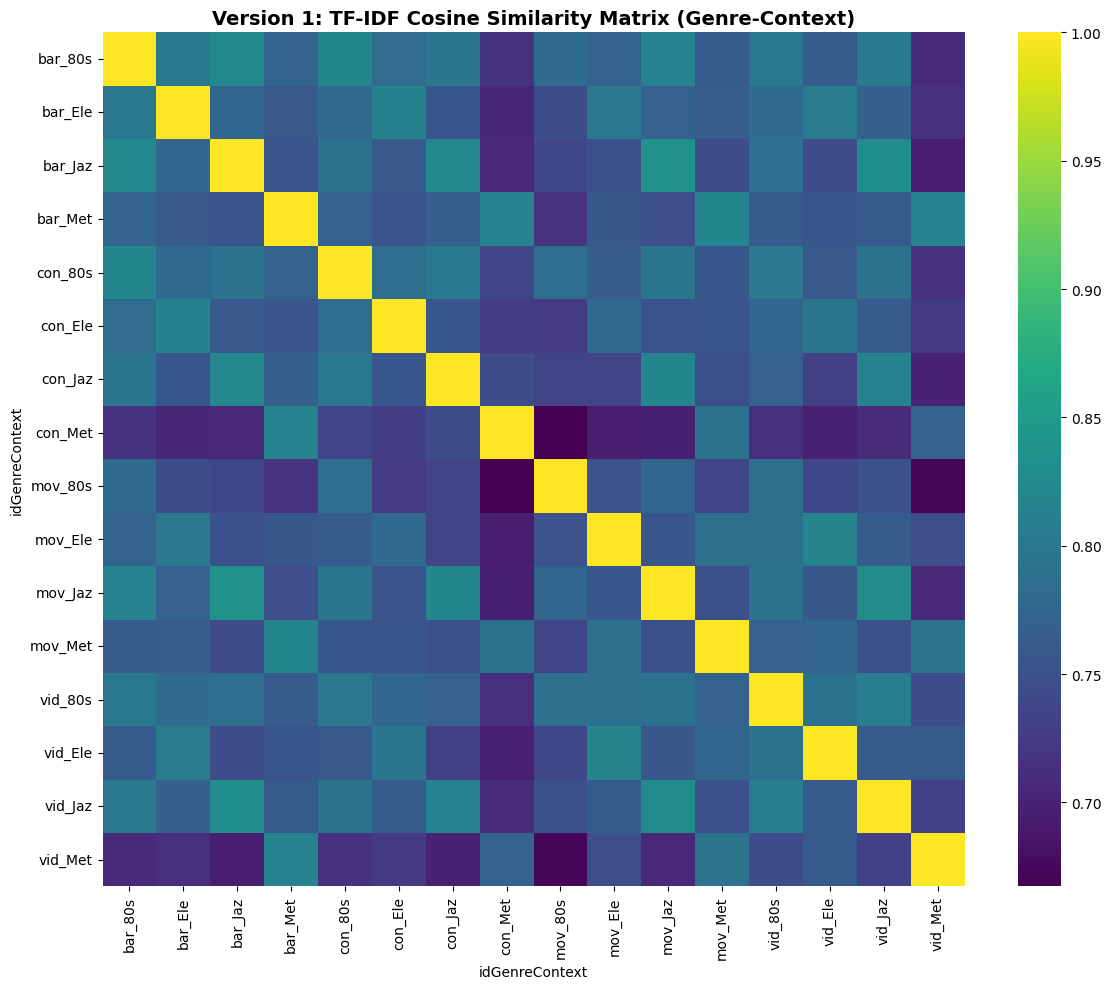

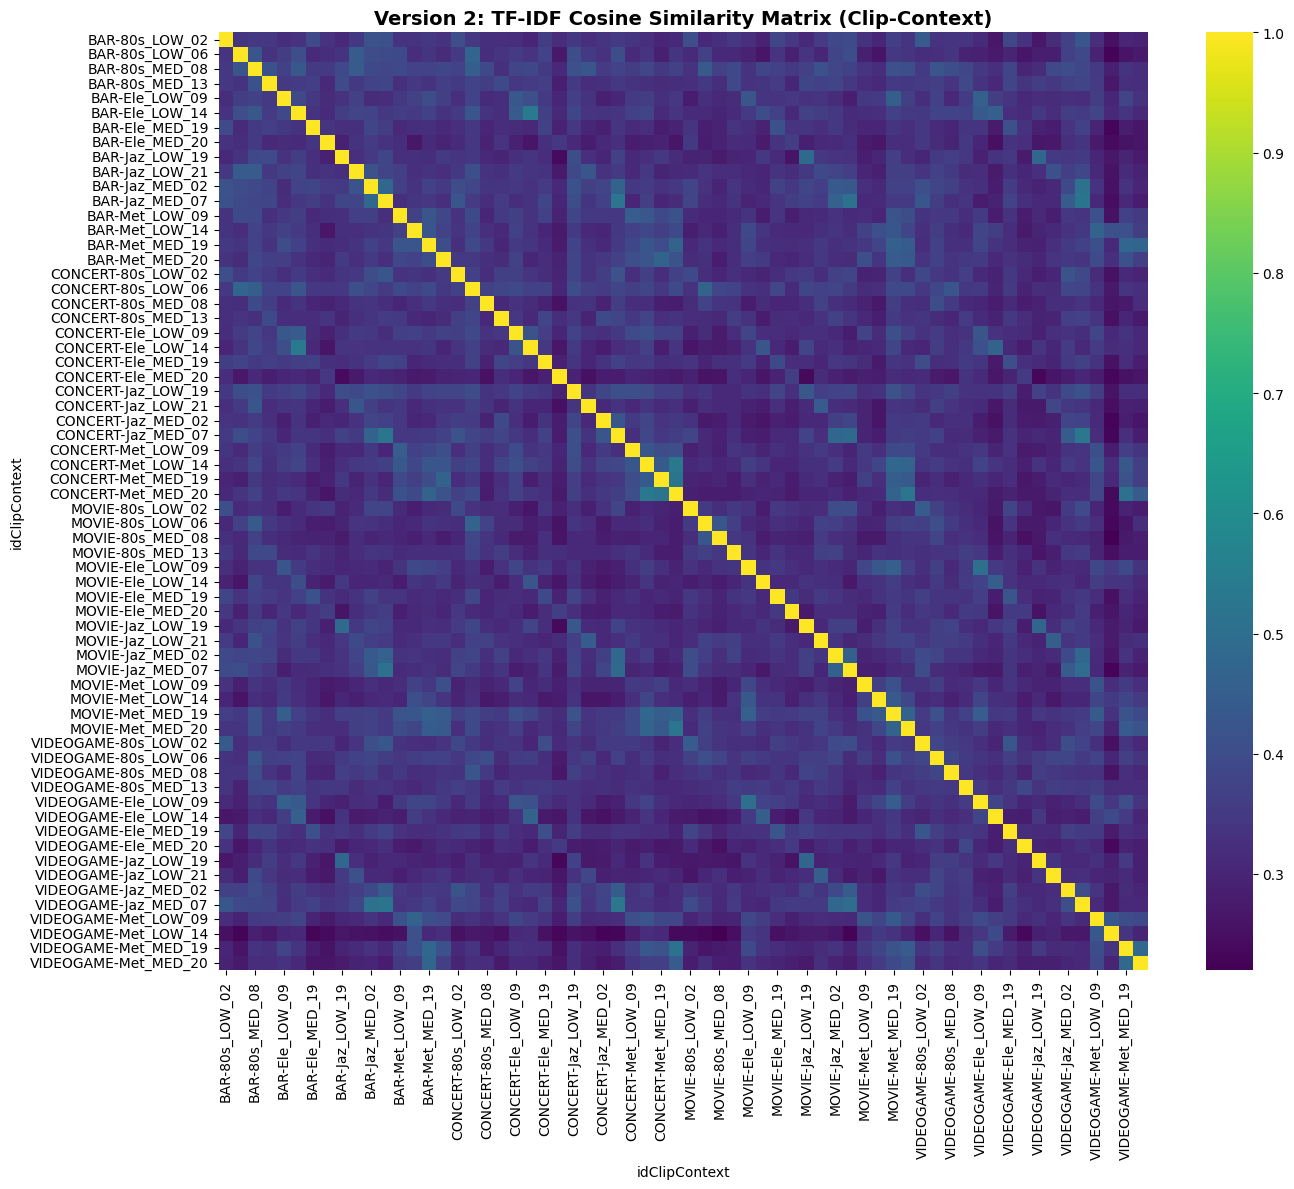

In [8]:
# Visualisation for Version 1
plt.figure(figsize=(12, 10))
sns.heatmap(cosineMatrix_TFIDF_v1_df, cmap='viridis', annot=False)
plt.title('Version 1: TF-IDF Cosine Similarity Matrix (Genre-Context)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/TFIDF/heatmap_TFIDF_v1_GenreContext.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualisation for Version 2
plt.figure(figsize=(14, 12))
sns.heatmap(cosineMatrix_TFIDF_v2_df, cmap='viridis', annot=False)
plt.title('Version 2: TF-IDF Cosine Similarity Matrix (Clip-Context)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/TFIDF/heatmap_TFIDF_v2_ClipContext.png', dpi=300, bbox_inches='tight')
plt.show()

### SUMMARY

In [9]:
print("\nOutput files created:")
print("  - TFIDF_scores_v1_ClipContext.csv")
print("  - ccosineMatrix_TFIDF_v1_ClipContext.csv")
print("  - heatmap_TFIDF_v1_ClipContext.png")
print("  - TFIDF_scores_v2_ClipContext.csv")
print("  - cosineMatrix_TFIDF_v2_ClipContext.csv")
print("  - heatmap_TFIDF_v2_ClipContext.png")


Output files created:
  - TFIDF_scores_v1_ClipContext.csv
  - ccosineMatrix_TFIDF_v1_ClipContext.csv
  - heatmap_TFIDF_v1_ClipContext.png
  - TFIDF_scores_v2_ClipContext.csv
  - cosineMatrix_TFIDF_v2_ClipContext.csv
  - heatmap_TFIDF_v2_ClipContext.png


---
## Semantic Similarity Analyses

**OUTPUTS:**

All Representational Dissimilarity Matrix (RDM) masks and similarity measures are saved separately for each version, ready for statistical analysis in R.

=== *ANALYSIS STRUCTURE* ===


**Version 1 (Genre-Context) - 5 conditions:**

* Same context, different genre
* Different context, same genre
* Different context, different genre
* Between (dif.) contexts
* Between (dif.) genres


**Version 2 (Clip-Context) - 7 conditions:**

* Same context, different clip
* Different context, same clip
* Different context, different clip
* Between (dif.) contexts
* Between (dif.) clips
* Between (dif.) genres
* Within (same) genre



====================================
### Version 1: Genre-Context Semantic Similarity
====================================

Set up label columns, NumPy arrays, and stimuli condition masks:

In [10]:
inData_tfidf_v1 = METdocs_v1
simData_tfidf_v1 = cosineMatrix_TFIDF_v1_df

# Extract label columns
labelsCG_tfidf_v1 = inData_tfidf_v1['idGenreContext']
labelsGenre_tfidf_v1 = inData_tfidf_v1['genre_code']
labelsContext_tfidf_v1 = inData_tfidf_v1['context_code']

# Initialise arrays
sContext_dGenre_tfidf_v1 = np.zeros(shape=(len(labelsCG_tfidf_v1), len(labelsCG_tfidf_v1)))
dContext_sGenre_tfidf_v1 = np.zeros(shape=(len(labelsCG_tfidf_v1), len(labelsCG_tfidf_v1)))
dContext_dGenre_tfidf_v1 = np.zeros(shape=(len(labelsCG_tfidf_v1), len(labelsCG_tfidf_v1)))
bwContext_tfidf_v1 = np.zeros(shape=(len(labelsCG_tfidf_v1), len(labelsCG_tfidf_v1)))
bwGenre_tfidf_v1 = np.zeros(shape=(len(labelsCG_tfidf_v1), len(labelsCG_tfidf_v1)))

# Build condition masks
for irow in range(0, len(labelsCG_tfidf_v1.values)):
    for icol in range(0, irow):
        same_context = labelsContext_tfidf_v1.values[irow] == labelsContext_tfidf_v1.values[icol]
        same_genre = labelsGenre_tfidf_v1.values[irow] == labelsGenre_tfidf_v1.values[icol]

        # Stimuli combinatorial conditions
        if same_context and not same_genre:
            sContext_dGenre_tfidf_v1[irow, icol] = 1
        elif not same_context and same_genre:
            dContext_sGenre_tfidf_v1[irow, icol] = 1
        elif not same_context and not same_genre:
            dContext_dGenre_tfidf_v1[irow, icol] = 1

        # Between context
        if not same_context:
            bwContext_tfidf_v1[irow, icol] = 1

        # Between genre
        if not same_genre:
            bwGenre_tfidf_v1[irow, icol] = 1

Extract similarity values for each condition:

In [11]:
simMeasures_tfidf_v1 = {'type': [], 'sim': []}

conditions_tfidf_v1 = {
    'sContext_dGenre': sContext_dGenre_tfidf_v1,
    'dContext_sGenre': dContext_sGenre_tfidf_v1,
    'dContext_dGenre': dContext_dGenre_tfidf_v1,
    'bwContext': bwContext_tfidf_v1,
    'bwGenre': bwGenre_tfidf_v1
}

for condition_name, condition_mask in conditions_tfidf_v1.items():
    simVals = simData_tfidf_v1.values[condition_mask == 1]
    for val in simVals:
        simMeasures_tfidf_v1['type'].append(condition_name)
        simMeasures_tfidf_v1['sim'].append(val)

# Create DataFrame
simMeasuresDF_tfidf_v1 = pd.DataFrame(data=simMeasures_tfidf_v1)
simMeasuresDF_tfidf_v1 = simMeasuresDF_tfidf_v1.replace([np.inf, -np.inf], np.nan)

print(f"\nVersion 1 TF-IDF Similarity Measures extracted (5 conditions):")
print(simMeasuresDF_tfidf_v1.groupby('type').agg({'sim': ['count', 'mean', 'std']}))

# Save outputs
simMeasuresDF_tfidf_v1.to_csv('/content/context-framed-listening/NLP_outputs/TFIDF/simMeasuresDF_TFIDF_v1_GenreContext.csv', encoding='utf-8', index=False)
pd.DataFrame(sContext_dGenre_tfidf_v1).to_csv('/content/context-framed-listening/NLP_outputs/TFIDF/RDM_sContext_dGenre_TFIDF_v1.csv', encoding='utf-8')
pd.DataFrame(dContext_sGenre_tfidf_v1).to_csv('/content/context-framed-listening/NLP_outputs/TFIDF/RDM_dContext_sGenre_TFIDF_v1.csv', encoding='utf-8')
pd.DataFrame(dContext_dGenre_tfidf_v1).to_csv('/content/context-framed-listening/NLP_outputs/TFIDF/RDM_dContext_dGenre_TFIDF_v1.csv', encoding='utf-8')
pd.DataFrame(bwContext_tfidf_v1).to_csv('/content/context-framed-listening/NLP_outputs/TFIDF/RDM_bwContext_TFIDF_v1.csv', encoding='utf-8')
pd.DataFrame(bwGenre_tfidf_v1).to_csv('/content/context-framed-listening/NLP_outputs/TFIDF/RDM_bwGenre_TFIDF_v1.csv', encoding='utf-8')



Version 1 TF-IDF Similarity Measures extracted (5 conditions):
                  sim                    
                count      mean       std
type                                     
bwContext          96  0.762543  0.038378
bwGenre            96  0.752616  0.031655
dContext_dGenre    72  0.748137  0.032227
dContext_sGenre    24  0.805758  0.016710
sContext_dGenre    24  0.766052  0.026106


====================================
### Version 2: Clip-Context Semantic Similarity
====================================

Set up label columns, NumPy arrays, and stimuli condition masks:

In [12]:
inData_tfidf_v2 = METdocs_v2
simData_tfidf_v2 = cosineMatrix_TFIDF_v2_df

# Extract label columns
labelsCG_tfidf_v2 = inData_tfidf_v2['idClipContext']
labelsClip_tfidf_v2 = inData_tfidf_v2['clip_name']
labelsGenre_tfidf_v2 = inData_tfidf_v2['genre_code']
labelsContext_tfidf_v2 = inData_tfidf_v2['context_word']

# Initialise arrays
sContext_dClip_tfidf_v2 = np.zeros(shape=(len(labelsCG_tfidf_v2), len(labelsCG_tfidf_v2)))
dContext_sClip_tfidf_v2 = np.zeros(shape=(len(labelsCG_tfidf_v2), len(labelsCG_tfidf_v2)))
dContext_dClip_tfidf_v2 = np.zeros(shape=(len(labelsCG_tfidf_v2), len(labelsCG_tfidf_v2)))
bwContext_tfidf_v2 = np.zeros(shape=(len(labelsCG_tfidf_v2), len(labelsCG_tfidf_v2)))
bwClip_tfidf_v2 = np.zeros(shape=(len(labelsCG_tfidf_v2), len(labelsCG_tfidf_v2)))
bwGenre_tfidf_v2 = np.zeros(shape=(len(labelsCG_tfidf_v2), len(labelsCG_tfidf_v2)))
wiGenre_tfidf_v2 = np.zeros(shape=(len(labelsCG_tfidf_v2), len(labelsCG_tfidf_v2)))

# Build condition masks
for irow in range(0, len(labelsCG_tfidf_v2.values)):
    for icol in range(0, irow):
        same_context = labelsContext_tfidf_v2.values[irow] == labelsContext_tfidf_v2.values[icol]
        same_clip = labelsClip_tfidf_v2.values[irow] == labelsClip_tfidf_v2.values[icol]
        same_genre = labelsGenre_tfidf_v2.values[irow] == labelsGenre_tfidf_v2.values[icol]

        # Stimuli combinatorial conditions
        if same_context and not same_clip:
            sContext_dClip_tfidf_v2[irow, icol] = 1
        elif not same_context and same_clip:
            dContext_sClip_tfidf_v2[irow, icol] = 1
        elif not same_context and not same_clip:
            dContext_dClip_tfidf_v2[irow, icol] = 1

        # Between context
        if not same_context:
            bwContext_tfidf_v2[irow, icol] = 1

        # Between clip
        if not same_clip:
            bwClip_tfidf_v2[irow, icol] = 1

        # Within/Between genre
        if same_genre:
            wiGenre_tfidf_v2[irow, icol] = 1
        else:
            bwGenre_tfidf_v2[irow, icol] = 1

Extract similarity values for each condition:

In [13]:
simMeasures_tfidf_v2 = {'type': [], 'sim': []}

conditions_tfidf_v2 = {
    'sContext_dClip': sContext_dClip_tfidf_v2,
    'dContext_sClip': dContext_sClip_tfidf_v2,
    'dContext_dClip': dContext_dClip_tfidf_v2,
    'bwContext': bwContext_tfidf_v2,
    'bwClip': bwClip_tfidf_v2,
    'bwGenre': bwGenre_tfidf_v2,
    'wiGenre': wiGenre_tfidf_v2
}

for condition_name, condition_mask in conditions_tfidf_v2.items():
    simVals = simData_tfidf_v2.values[condition_mask == 1]
    for val in simVals:
        simMeasures_tfidf_v2['type'].append(condition_name)
        simMeasures_tfidf_v2['sim'].append(val)

# Create DataFrame
simMeasuresDF_tfidf_v2 = pd.DataFrame(data=simMeasures_tfidf_v2)
simMeasuresDF_tfidf_v2 = simMeasuresDF_tfidf_v2.replace([np.inf, -np.inf], np.nan)

print(f"\nVersion 2 TF-IDF Similarity Measures extracted (7 conditions):")
print(simMeasuresDF_tfidf_v2.groupby('type').agg({'sim': ['count', 'mean', 'std']}))

# Save outputs
simMeasuresDF_tfidf_v2.to_csv('/content/context-framed-listening/NLP_outputs/TFIDF/simMeasuresDF_TFIDF_v2_ClipContext.csv', encoding='utf-8', index=False)
pd.DataFrame(sContext_dClip_tfidf_v2).to_csv('/content/context-framed-listening/NLP_outputs/TFIDF/RDM_sContext_dClip_TFIDF_v2.csv', encoding='utf-8')
pd.DataFrame(dContext_sClip_tfidf_v2).to_csv('/content/context-framed-listening/NLP_outputs/TFIDF/RDM_dContext_sClip_TFIDF_v2.csv', encoding='utf-8')
pd.DataFrame(dContext_dClip_tfidf_v2).to_csv('/content/context-framed-listening/NLP_outputs/TFIDF/RDM_dContext_dClip_TFIDF_v2.csv', encoding='utf-8')
pd.DataFrame(bwContext_tfidf_v2).to_csv('/content/context-framed-listening/NLP_outputs/TFIDF/RDM_bwContext_TFIDF_v2.csv', encoding='utf-8')
pd.DataFrame(bwClip_tfidf_v2).to_csv('/content/context-framed-listening/NLP_outputs/TFIDF/RDM_bwClip_TFIDF_v2.csv', encoding='utf-8')
pd.DataFrame(bwGenre_tfidf_v2).to_csv('/content/context-framed-listening/NLP_outputs/TFIDF/RDM_bwGenre_TFIDF_v2.csv', encoding='utf-8')
pd.DataFrame(wiGenre_tfidf_v2).to_csv('/content/context-framed-listening/NLP_outputs/TFIDF/RDM_wiGenre_TFIDF_v2.csv', encoding='utf-8')


Version 2 TF-IDF Similarity Measures extracted (7 conditions):
                 sim                    
               count      mean       std
type                                    
bwClip          1920  0.331327  0.040339
bwContext       1536  0.333123  0.045148
bwGenre         1536  0.325610  0.035149
dContext_dClip  1440  0.327911  0.039616
dContext_sClip    96  0.411314  0.050722
sContext_dClip   480  0.341575  0.040791
wiGenre          480  0.365619  0.055401


====================================
#### VISUALISATIONS for TF-IDF measures
====================================

* Box plots
* Violin plots
* Bar plots

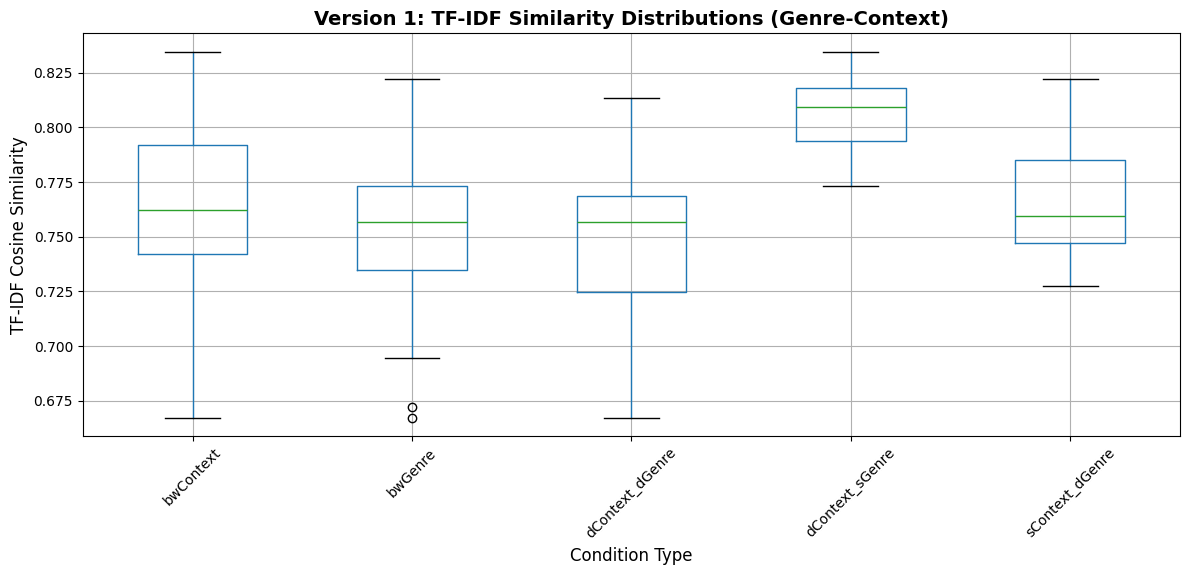

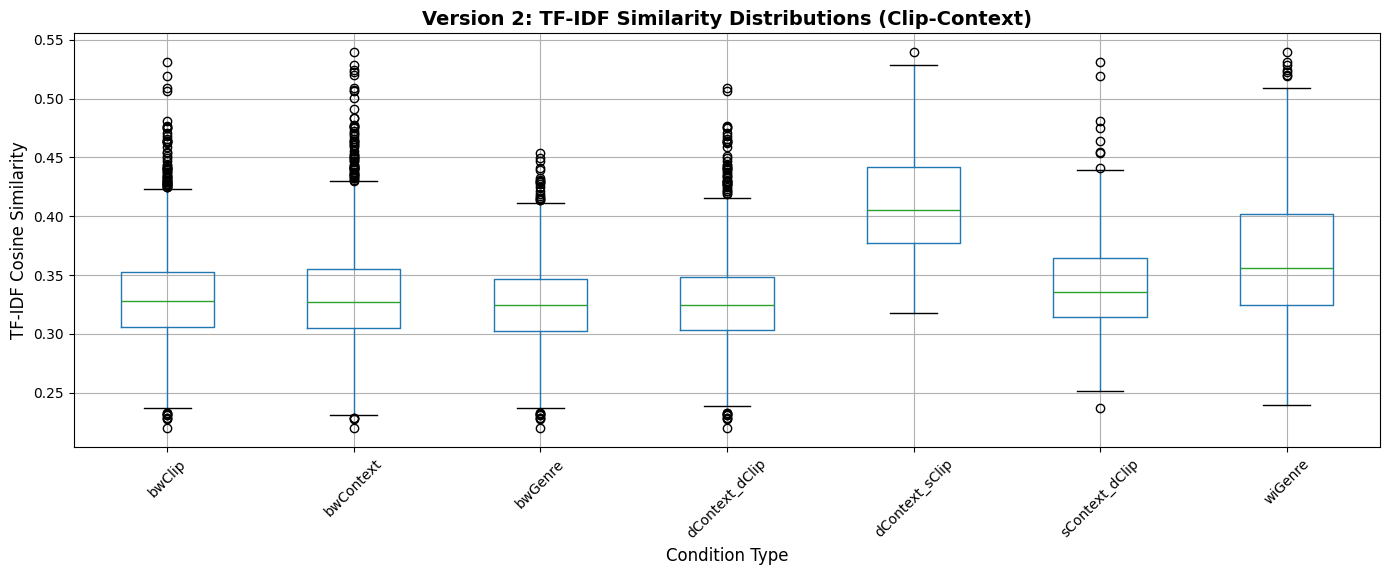

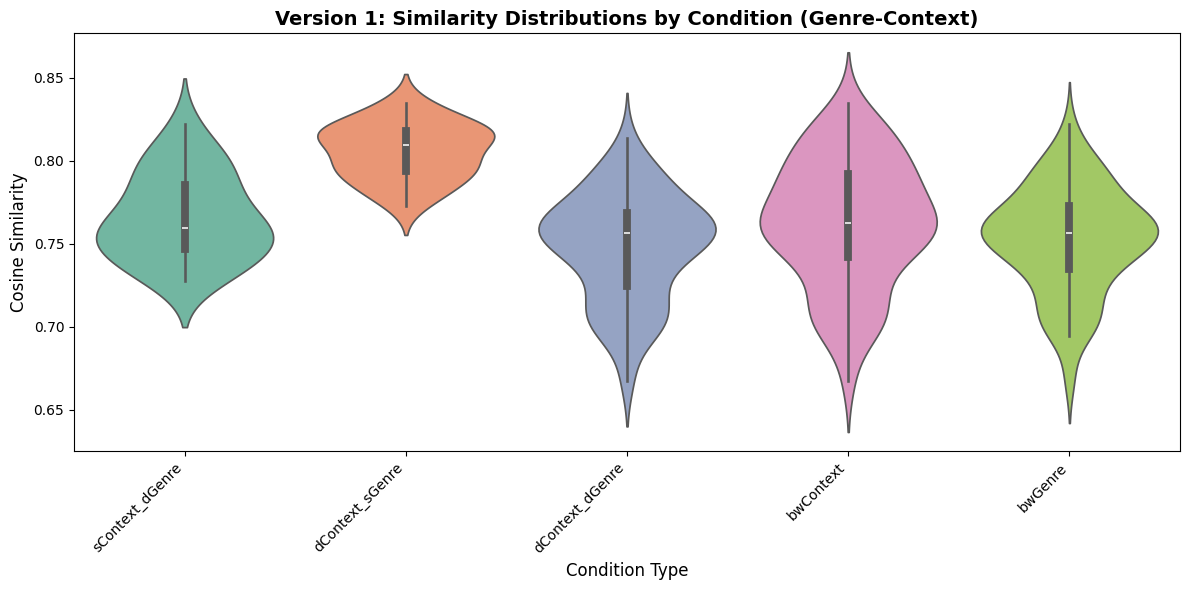

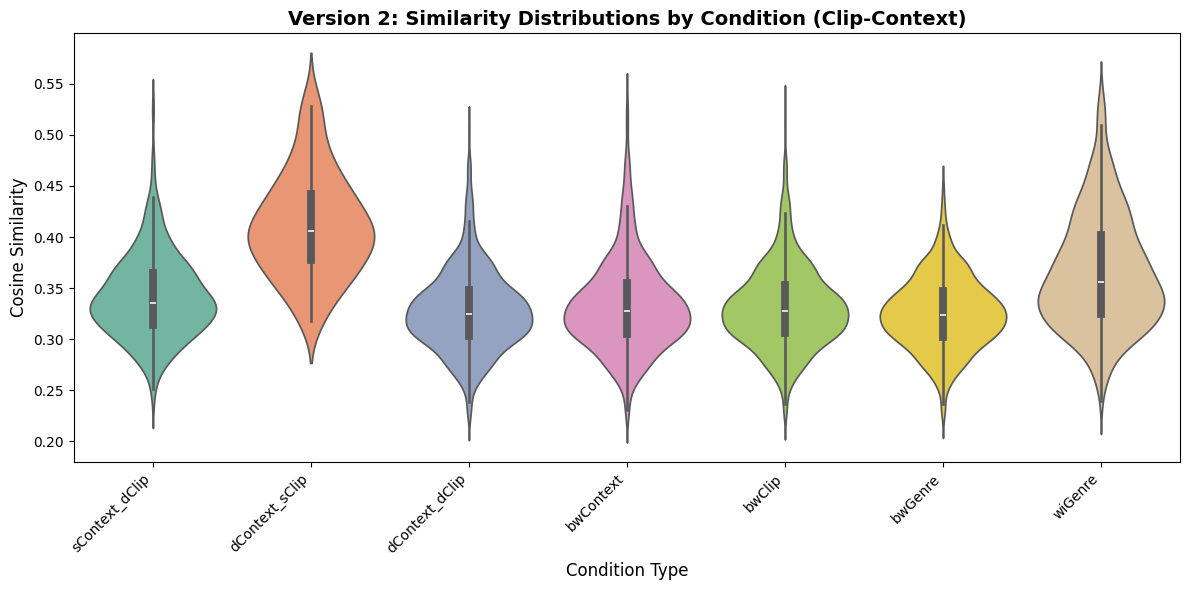

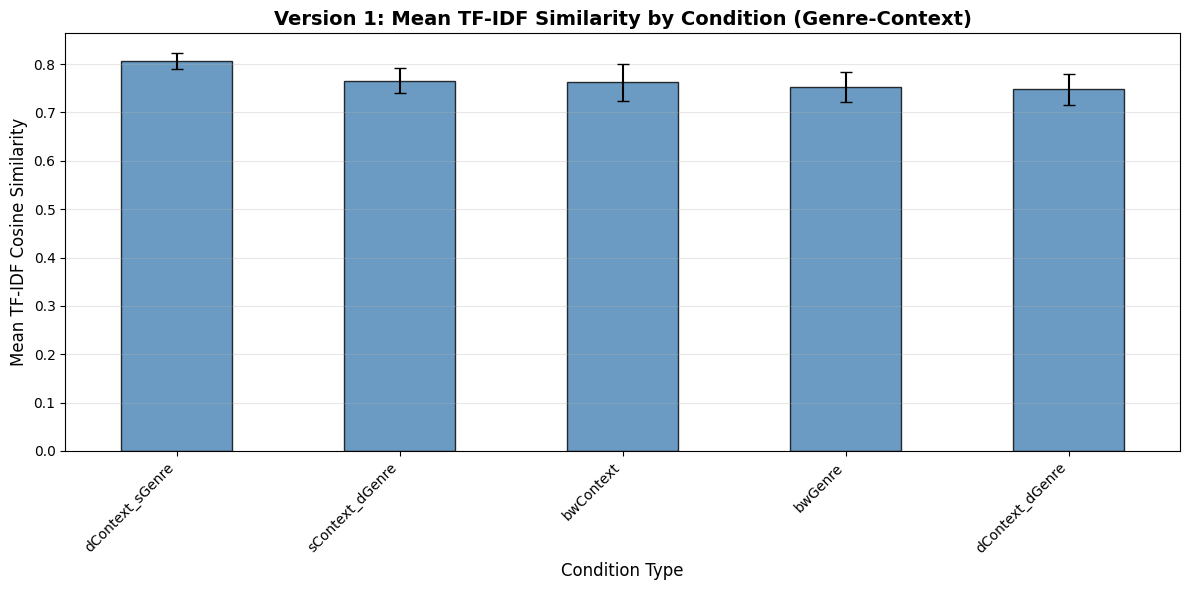

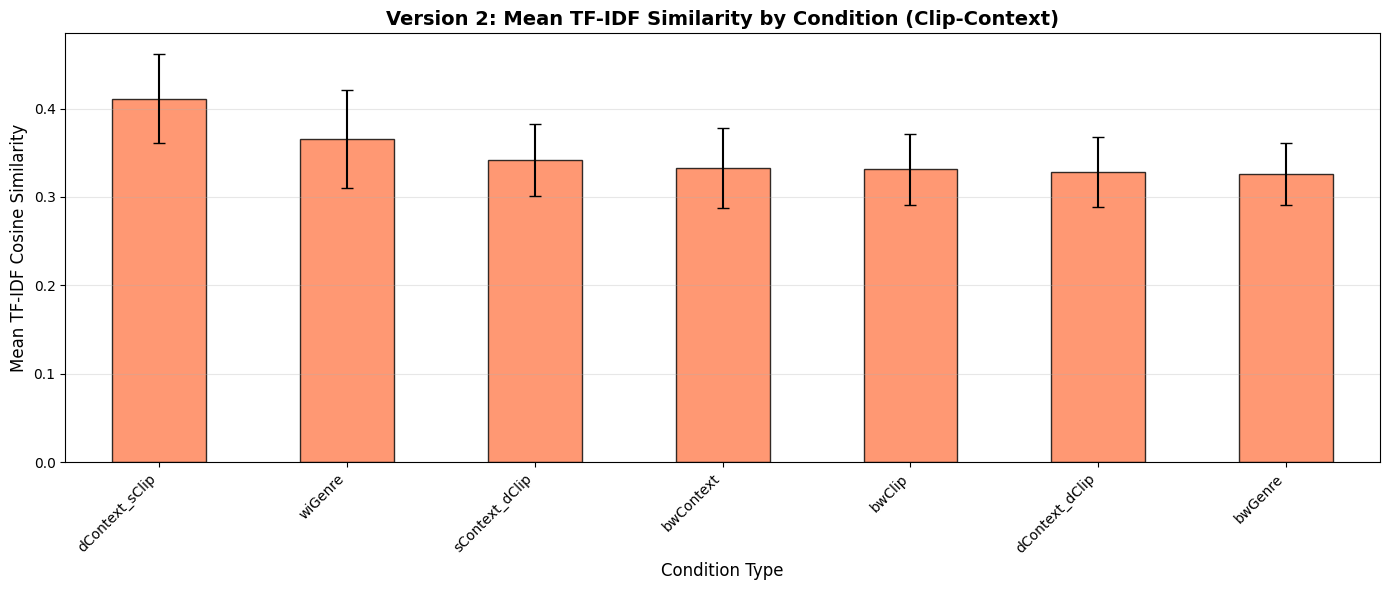

In [14]:
# Box plots comparing conditions - Version 1
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
simMeasuresDF_tfidf_v1.boxplot(column='sim', by='type', ax=ax, rot=45)
ax.set_title('Version 1: TF-IDF Similarity Distributions (Genre-Context)', fontsize=14, fontweight='bold')
ax.set_xlabel('Condition Type', fontsize=12)
ax.set_ylabel('TF-IDF Cosine Similarity', fontsize=12)
plt.suptitle('')
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/TFIDF/similarity_boxplot_TFIDF_v1_GenreContext.png', dpi=300, bbox_inches='tight')
plt.show()

# Box plots comparing conditions - Version 2
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
simMeasuresDF_tfidf_v2.boxplot(column='sim', by='type', ax=ax, rot=45)
ax.set_title('Version 2: TF-IDF Similarity Distributions (Clip-Context)', fontsize=14, fontweight='bold')
ax.set_xlabel('Condition Type', fontsize=12)
ax.set_ylabel('TF-IDF Cosine Similarity', fontsize=12)
plt.suptitle('')
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/TFIDF/similarity_boxplot_TFIDF_v2_ClipContext.png', dpi=300, bbox_inches='tight')
plt.show()

# Violin plot comparing conditions - Version 1
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.violinplot(data=simMeasuresDF_tfidf_v1, x='type', y='sim', hue='type', ax=ax, palette='Set2', legend=False)
ax.set_title('Version 1: Similarity Distributions by Condition (Genre-Context)', fontsize=14, fontweight='bold')
ax.set_xlabel('Condition Type', fontsize=12)
ax.set_ylabel('Cosine Similarity', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/TFIDF/similarity_violin_TFIDF_v1_GenreContext.png', dpi=300, bbox_inches='tight')
plt.show()

# Violin plot comparing conditions - Version 2
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.violinplot(data=simMeasuresDF_tfidf_v2, x='type', y='sim', hue='type', ax=ax, palette='Set2', legend=False)
ax.set_title('Version 2: Similarity Distributions by Condition (Clip-Context)', fontsize=14, fontweight='bold')
ax.set_xlabel('Condition Type', fontsize=12)
ax.set_ylabel('Cosine Similarity', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/TFIDF/similarity_violin_TFIDF_v2_GenreContext.png', dpi=300, bbox_inches='tight')
plt.show()

# Bar plots with means - Version 1
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
means_tfidf_v1 = simMeasuresDF_tfidf_v1.groupby('type')['sim'].mean().sort_values(ascending=False)
stds_tfidf_v1 = simMeasuresDF_tfidf_v1.groupby('type')['sim'].std()
means_tfidf_v1.plot(kind='bar', ax=ax, yerr=stds_tfidf_v1, capsize=4, color='steelblue', edgecolor='black', alpha=0.8)
ax.set_title('Version 1: Mean TF-IDF Similarity by Condition (Genre-Context)', fontsize=14, fontweight='bold')
ax.set_xlabel('Condition Type', fontsize=12)
ax.set_ylabel('Mean TF-IDF Cosine Similarity', fontsize=12)
ax.set_xticklabels(means_tfidf_v1.index, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/TFIDF/similarity_means_TFIDF_v1_GenreContext.png', dpi=300, bbox_inches='tight')
plt.show()

# Bar plots with means - Version 2
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
means_tfidf_v2 = simMeasuresDF_tfidf_v2.groupby('type')['sim'].mean().sort_values(ascending=False)
stds_tfidf_v2 = simMeasuresDF_tfidf_v2.groupby('type')['sim'].std()
means_tfidf_v2.plot(kind='bar', ax=ax, yerr=stds_tfidf_v2, capsize=4, color='coral', edgecolor='black', alpha=0.8)
ax.set_title('Version 2: Mean TF-IDF Similarity by Condition (Clip-Context)', fontsize=14, fontweight='bold')
ax.set_xlabel('Condition Type', fontsize=12)
ax.set_ylabel('Mean TF-IDF Cosine Similarity', fontsize=12)
ax.set_xticklabels(means_tfidf_v2.index, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/TFIDF/similarity_means_TFIDF_v2_ClipContext.png', dpi=300, bbox_inches='tight')
plt.show()

### SUMMARY

In [15]:
print("\nVersion 1 (Genre-Context) TF-IDF Output Files:")
print("  Data Files:")
print("    - TFIDF_scores_v1_GenreContext.csv")
print("    - cosineMatrix_TFIDF_v1_GenreContext.csv")
print("    - simMeasuresDF_TFIDF_v1_GenreContext.csv")
print("    - RDM masks (8 CSV files)")
print("  Visualisations:")
print("    - heatmap_TFIDF_v1_GenreContext.png")
print("    - similarity_boxplot_TFIDF_v1_GenreContext.png")
print("    - similarity_violin_TFIDF_v1_GenreContext.png")
print("    - similarity_means_TFIDF_v1_GenreContext.png")
print("\nVersion 2 (Clip-Context) TF-IDF Output Files:")
print("  Data Files:")
print("    - TFIDF_scores_v2_ClipContext.csv")
print("    - cosineMatrix_TFIDF_v2_ClipContext.csv")
print("    - simMeasuresDF_TFIDF_v2_ClipContext.csv")
print("    - RDM masks (10 CSV files)")
print("  Visualisations:")
print("    - heatmap_TFIDF_v2_ClipContext.png")
print("    - similarity_boxplot_TFIDF_v2_ClipContext.png")
print("    - similarity_violin_TFIDF_v2_GenreContext.png")
print("    - similarity_means_TFIDF_v2_ClipContext.png")


Version 1 (Genre-Context) TF-IDF Output Files:
  Data Files:
    - TFIDF_scores_v1_GenreContext.csv
    - cosineMatrix_TFIDF_v1_GenreContext.csv
    - simMeasuresDF_TFIDF_v1_GenreContext.csv
    - RDM masks (8 CSV files)
  Visualisations:
    - heatmap_TFIDF_v1_GenreContext.png
    - similarity_boxplot_TFIDF_v1_GenreContext.png
    - similarity_violin_TFIDF_v1_GenreContext.png
    - similarity_means_TFIDF_v1_GenreContext.png

Version 2 (Clip-Context) TF-IDF Output Files:
  Data Files:
    - TFIDF_scores_v2_ClipContext.csv
    - cosineMatrix_TFIDF_v2_ClipContext.csv
    - simMeasuresDF_TFIDF_v2_ClipContext.csv
    - RDM masks (10 CSV files)
  Visualisations:
    - heatmap_TFIDF_v2_ClipContext.png
    - similarity_boxplot_TFIDF_v2_ClipContext.png
    - similarity_violin_TFIDF_v2_GenreContext.png
    - similarity_means_TFIDF_v2_ClipContext.png
